<a href="https://colab.research.google.com/github/jkeza1/time_series_forecasting/blob/main/air_quality_forecasting_starter_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beijing Air Quality Forecasting Starter Notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2
from sklearn.preprocessing import RobustScaler, QuantileTransformer
from tensorflow.keras.losses import Huber
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [4]:
print(" Training Data Overview:")
train.head()

train.columns

 Training Data Overview:


Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [5]:
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

In [6]:
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [7]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [8]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

In [9]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train = np.expand_dims(X_train, axis=1)

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

def create_advanced_features(df, target_col='pm2.5'):
    """Create lag features, rolling statistics, and temporal features"""
    df_enhanced = df.copy()

    # Temporal features
    df_enhanced['hour'] = df_enhanced.index.hour
    df_enhanced['day_of_week'] = df_enhanced.index.dayofweek
    df_enhanced['month'] = df_enhanced.index.month
    df_enhanced['season'] = (df_enhanced.index.month % 12 + 3) // 3
    df_enhanced['is_weekend'] = df_enhanced['day_of_week'].isin([5, 6]).astype(int)

    # Cyclical encoding for temporal features
    df_enhanced['hour_sin'] = np.sin(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['hour_cos'] = np.cos(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['day_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['day_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['month_sin'] = np.sin(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['month_cos'] = np.cos(2 * np.pi * df_enhanced['month'] / 12)

    if target_col in df_enhanced.columns:
        # Lag features for PM2.5
        for lag in [1, 2, 3, 6, 12, 24, 48]:
            df_enhanced[f'pm2.5_lag_{lag}'] = df_enhanced[target_col].shift(lag)

        # Rolling statistics for PM2.5
        for window in [6, 12, 24, 48]:
            df_enhanced[f'pm2.5_roll_mean_{window}'] = df_enhanced[target_col].rolling(window, min_periods=1).mean()
            df_enhanced[f'pm2.5_roll_std_{window}'] = df_enhanced[target_col].rolling(window, min_periods=1).std()
            df_enhanced[f'pm2.5_roll_min_{window}'] = df_enhanced[target_col].rolling(window, min_periods=1).min()
            df_enhanced[f'pm2.5_roll_max_{window}'] = df_enhanced[target_col].rolling(window, min_periods=1).max()

    # Weather interaction features
    df_enhanced['temp_dewp_diff'] = df_enhanced['TEMP'] - df_enhanced['DEWP']
    df_enhanced['wind_pressure'] = df_enhanced['Iws'] * df_enhanced['PRES']
    df_enhanced['humidity_index'] = df_enhanced['DEWP'] / (df_enhanced['TEMP'] + 1e-6)

    # Rolling features for weather variables
    for col in ['DEWP', 'TEMP', 'PRES', 'Iws']:
        for window in [6, 12, 24]:
            df_enhanced[f'{col}_roll_mean_{window}'] = df_enhanced[col].rolling(window, min_periods=1).mean()
            df_enhanced[f'{col}_roll_std_{window}'] = df_enhanced[col].rolling(window, min_periods=1).std()

    # Wind direction features
    wind_cols = [col for col in df_enhanced.columns if 'cbwd' in col]
    if len(wind_cols) >= 2:
        df_enhanced['wind_complexity'] = sum(df_enhanced[col] for col in wind_cols)

    # Drop original temporal columns (keep encoded versions)
    df_enhanced = df_enhanced.drop(['hour', 'day_of_week', 'month'], axis=1)

    return df_enhanced

def create_test_features(df):
    """Create features for test data (without PM2.5 lag features)"""
    df_enhanced = df.copy()

    # Temporal features
    df_enhanced['hour'] = df_enhanced.index.hour
    df_enhanced['day_of_week'] = df_enhanced.index.dayofweek
    df_enhanced['month'] = df_enhanced.index.month
    df_enhanced['season'] = (df_enhanced.index.month % 12 + 3) // 3
    df_enhanced['is_weekend'] = df_enhanced['day_of_week'].isin([5, 6]).astype(int)

    # Cyclical encoding for temporal features
    df_enhanced['hour_sin'] = np.sin(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['hour_cos'] = np.cos(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['day_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['day_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['month_sin'] = np.sin(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['month_cos'] = np.cos(2 * np.pi * df_enhanced['month'] / 12)

    # Weather interaction features
    df_enhanced['temp_dewp_diff'] = df_enhanced['TEMP'] - df_enhanced['DEWP']
    df_enhanced['wind_pressure'] = df_enhanced['Iws'] * df_enhanced['PRES']
    df_enhanced['humidity_index'] = df_enhanced['DEWP'] / (df_enhanced['TEMP'] + 1e-6)

    # Rolling features for weather variables
    for col in ['DEWP', 'TEMP', 'PRES', 'Iws']:
        for window in [6, 12, 24]:
            df_enhanced[f'{col}_roll_mean_{window}'] = df_enhanced[col].rolling(window, min_periods=1).mean()
            df_enhanced[f'{col}_roll_std_{window}'] = df_enhanced[col].rolling(window, min_periods=1).std()

    # Wind direction features
    wind_cols = [col for col in df_enhanced.columns if 'cbwd' in col]
    if len(wind_cols) >= 2:
        df_enhanced['wind_complexity'] = sum(df_enhanced[col] for col in wind_cols)

    # Drop original temporal columns
    df_enhanced = df_enhanced.drop(['hour', 'day_of_week', 'month'], axis=1)

    return df_enhanced

def save_submission(predictions, experiment_name, test_index):
    """Save submission with timestamp and experiment info"""
    os.makedirs('submissions', exist_ok=True)

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    # Manual formatting to ensure no leading zeros in hours
    row_ids = []
    for dt in test_index:
        # Format: "YYYY-MM-DD H:MM:SS" (no leading zero for hour)
        formatted = f"{dt.year}-{dt.month:02d}-{dt.day:02d} {dt.hour}:{dt.minute:02d}:{dt.second:02d}"
        row_ids.append(formatted)

    submission = pd.DataFrame({
        'row ID': row_ids,
        'pm2.5': predictions.round().astype(int)
    })

    filename = f'submissions/{timestamp}_{experiment_name}.csv'
    submission.to_csv(filename, index=False)

    print(f"✅ Submission saved: {filename}")
    print(f"📊 Predictions - Min: {predictions.min():.1f}, Max: {predictions.max():.1f}")
    print(f"📋 Sample format: {row_ids[0]}")

    return filename, submission

print("✅ All functions defined successfully!")

✅ All functions defined successfully!


In [11]:
# Check if we have clean data
if 'train_clean' not in locals() or 'test_clean' not in locals():
    print("❌ Clean data not found. Please run data cleaning cells first.")
    # If you need to clean data, run this:
    train_clean = train.copy()
    train_clean = train_clean.fillna(method='ffill').fillna(method='bfill').fillna(0)
    test_clean = test.copy()
    test_clean = test_clean.fillna(method='ffill').fillna(method='bfill').fillna(0)
    print("✅ Data cleaned")

# 1. Feature Engineering
print("🔧 Creating advanced features...")
train_enhanced = create_advanced_features(train_clean, target_col='pm2.5')
test_enhanced = create_test_features(test_clean)

print(f"📊 Enhanced datasets - Train: {train_enhanced.shape}, Test: {test_enhanced.shape}")

# 2. Feature Alignment (Remove PM2.5-dependent features)
print("🔧 Aligning features...")
pm25_dependent_features = [col for col in train_enhanced.columns if 'pm2.5_' in col]
print(f"🚫 Removing PM2.5-dependent features: {pm25_dependent_features}")

common_features = [col for col in train_enhanced.columns
                  if col in test_enhanced.columns and col not in ['pm2.5', 'No']]

X_train_aligned = train_enhanced[common_features]
y_train = train_enhanced['pm2.5']
X_test_aligned = test_enhanced[common_features]

print(f"✅ Using {len(common_features)} common features")
print(f"📊 Aligned training features: {X_train_aligned.shape}")
print(f"📊 Aligned test features: {X_test_aligned.shape}")

# 3. Scale Features
print("🔧 Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_aligned)
X_test_scaled = scaler.transform(X_test_aligned)

print("✅ Feature scaling completed!")
print(f"📊 X_train_scaled shape: {X_train_scaled.shape}")
print(f"📊 X_test_scaled shape: {X_test_scaled.shape}")

❌ Clean data not found. Please run data cleaning cells first.
✅ Data cleaned
🔧 Creating advanced features...
📊 Enhanced datasets - Train: (30676, 70), Test: (13148, 46)
🔧 Aligning features...
🚫 Removing PM2.5-dependent features: ['pm2.5_lag_1', 'pm2.5_lag_2', 'pm2.5_lag_3', 'pm2.5_lag_6', 'pm2.5_lag_12', 'pm2.5_lag_24', 'pm2.5_lag_48', 'pm2.5_roll_mean_6', 'pm2.5_roll_std_6', 'pm2.5_roll_min_6', 'pm2.5_roll_max_6', 'pm2.5_roll_mean_12', 'pm2.5_roll_std_12', 'pm2.5_roll_min_12', 'pm2.5_roll_max_12', 'pm2.5_roll_mean_24', 'pm2.5_roll_std_24', 'pm2.5_roll_min_24', 'pm2.5_roll_max_24', 'pm2.5_roll_mean_48', 'pm2.5_roll_std_48', 'pm2.5_roll_min_48', 'pm2.5_roll_max_48']
✅ Using 45 common features
📊 Aligned training features: (30676, 45)
📊 Aligned test features: (13148, 45)
🔧 Scaling features...
✅ Feature scaling completed!
📊 X_train_scaled shape: (30676, 45)
📊 X_test_scaled shape: (13148, 45)


In [14]:
print("🔍 Checking available variables...")
available_vars = [var for var in ['X_train_scaled', 'X_train_aligned', 'y_train', 'SEQUENCE_LENGTH'] if var in locals()]
print(f"Available variables: {available_vars}")

# Check if we have the basic components
if 'X_train_scaled' in locals():
    print(f"X_train_scaled shape: {X_train_scaled.shape}")
if 'y_train' in locals():
    print(f"y_train shape: {y_train.shape}")
if 'SEQUENCE_LENGTH' in locals():
    print(f"SEQUENCE_LENGTH: {SEQUENCE_LENGTH}")
else:
    SEQUENCE_LENGTH = 36  # Set default if not defined
    print(f"Setting SEQUENCE_LENGTH to: {SEQUENCE_LENGTH}")

🔍 Checking available variables...
Available variables: ['X_train_scaled', 'X_train_aligned', 'y_train']
X_train_scaled shape: (30676, 45)
y_train shape: (30676,)
Setting SEQUENCE_LENGTH to: 36


In [15]:
import numpy as np

def create_sequences(data, target, sequence_length=24):
    """Create sequences for LSTM input"""
    X, y = [], []

    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(target[i])

    return np.array(X), np.array(y)

print("✅ create_sequences function defined")

✅ create_sequences function defined


In [17]:
print("🏗️ Creating time series sequences...")

# Make sure we have the required variables
if 'X_train_scaled' in locals() and 'y_train' in locals():
    X_seq, y_seq = create_sequences(X_train_scaled, y_train.values, SEQUENCE_LENGTH)

    # Train/validation split
    split_idx = int(0.85 * len(X_seq))
    X_train_seq, X_val_seq = X_seq[:split_idx], X_seq[split_idx:]
    y_train_seq, y_val_seq = y_seq[:split_idx], y_seq[split_idx:]

    print(f"✅ Sequences created successfully!")
    print(f"📊 X_train_seq shape: {X_train_seq.shape}")
    print(f"📊 y_train_seq shape: {y_train_seq.shape}")
    print(f"📊 X_val_seq shape: {X_val_seq.shape}")
    print(f"📊 y_val_seq shape: {y_val_seq.shape}")
else:
    print("❌ Missing required variables: X_train_scaled or y_train")
    print("Please run your data preparation cells first!")

🏗️ Creating time series sequences...
✅ Sequences created successfully!
📊 X_train_seq shape: (26044, 36, 45)
📊 y_train_seq shape: (26044,)
📊 X_val_seq shape: (4596, 36, 45)
📊 y_val_seq shape: (4596,)


In [18]:
# Now you can run your data check
print("🔍 Checking data for issues...")
print(f"X_train_seq - Min: {X_train_seq.min():.6f}, Max: {X_train_seq.max():.6f}")
print(f"X_train_seq - Contains NaN: {np.isnan(X_train_seq).any()}")
print(f"X_train_seq - Contains Inf: {np.isinf(X_train_seq).any()}")

print(f"y_train_seq - Min: {y_train_seq.min():.6f}, Max: {y_train_seq.max():.6f}")
print(f"y_train_seq - Contains NaN: {np.isnan(y_train_seq).any()}")
print(f"y_train_seq - Contains Inf: {np.isinf(y_train_seq).any()}")

# Additional checks
print(f"\n📊 Data statistics:")
print(f"X_train_seq shape: {X_train_seq.shape}")
print(f"X_train_seq dtype: {X_train_seq.dtype}")
print(f"y_train_seq dtype: {y_train_seq.dtype}")

🔍 Checking data for issues...
X_train_seq - Min: nan, Max: nan
X_train_seq - Contains NaN: True
X_train_seq - Contains Inf: False
y_train_seq - Min: 0.000000, Max: 994.000000
y_train_seq - Contains NaN: False
y_train_seq - Contains Inf: False

📊 Data statistics:
X_train_seq shape: (26044, 36, 45)
X_train_seq dtype: float64
y_train_seq dtype: float64


In [19]:
print("🔍 Checking data for issues...")
print(f"X_train_seq - Min: {X_train_seq.min():.6f}, Max: {X_train_seq.max():.6f}")
print(f"X_train_seq - Contains NaN: {np.isnan(X_train_seq).any()}")
print(f"X_train_seq - Contains Inf: {np.isinf(X_train_seq).any()}")

print(f"y_train_seq - Min: {y_train_seq.min():.6f}, Max: {y_train_seq.max():.6f}")
print(f"y_train_seq - Contains NaN: {np.isnan(y_train_seq).any()}")
print(f"y_train_seq - Contains Inf: {np.isinf(y_train_seq).any()}")

🔍 Checking data for issues...
X_train_seq - Min: nan, Max: nan
X_train_seq - Contains NaN: True
X_train_seq - Contains Inf: False
y_train_seq - Min: 0.000000, Max: 994.000000
y_train_seq - Contains NaN: False
y_train_seq - Contains Inf: False


In [20]:
print(X_train_seq.shape)
# should be (n_samples, SEQUENCE_LENGTH, n_features)


(26044, 36, 45)


Training final model

In [21]:
print("🔍 Checking input data dimensions...")
print(f"X_train shape: {X_train.shape if 'X_train' in locals() else 'X_train not defined'}")
print(f"X_train_seq shape: {X_train_seq.shape if 'X_train_seq' in locals() else 'X_train_seq not defined'}")
print(f"Number of features expected by model: 45")

🔍 Checking input data dimensions...
X_train shape: (30676, 1, 9)
X_train_seq shape: (26044, 36, 45)
Number of features expected by model: 45


In [22]:
# Check if you have the right number of features
print("📊 Feature dimension check:")
if 'X_train_aligned' in locals():
    print(f"X_train_aligned features: {X_train_aligned.shape[1]}")
if 'common_features' in locals():
    print(f"Common features count: {len(common_features)}")

📊 Feature dimension check:
X_train_aligned features: 45
Common features count: 45


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Attention
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def create_advanced_model(input_shape):
    """Advanced model with attention mechanism"""
    model = Sequential([
        # First Bidirectional LSTM with more units
        Bidirectional(LSTM(256, activation='tanh', return_sequences=True,
                         dropout=0.2, recurrent_dropout=0.2),
                    input_shape=input_shape),
        BatchNormalization(),

        # Second Bidirectional LSTM
        Bidirectional(LSTM(128, activation='tanh', return_sequences=True,
                         dropout=0.2, recurrent_dropout=0.2)),
        BatchNormalization(),

        # Third LSTM layer
        LSTM(64, activation='tanh', return_sequences=True, dropout=0.2),
        BatchNormalization(),

        # Attention layer (custom implementation)
        # You might need to implement attention or use transformer layers
        LSTM(32, activation='tanh', dropout=0.1),
        BatchNormalization(),
        Dropout(0.3),

        # Dense layers with advanced activations
        Dense(128, activation='swish', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(64, activation='swish'),
        Dense(32, activation='relu'),
        Dense(1, kernel_initializer='he_normal')
    ])

    return model

# Compile with advanced optimizer
model = create_advanced_model((SEQUENCE_LENGTH, X_train_seq.shape[2]))
model.compile(
    optimizer=AdamW(learning_rate=0.0005, weight_decay=1e-4),
    loss='huber',  # Better for outliers than MSE
    metrics=['mae', 'mse']
)

In [25]:
# Use the correct training data
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    verbose=1
)
callbacks = [
    EarlyStopping(patience=20, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=10)
]


print("🚀 Training model with correct dimensions...")
history = model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

🚀 Training model with correct dimensions...
Epoch 1/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 428s 1s/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan - learning_rate: 5.0000e-04
Epoch 2/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 421s 1s/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan - learning_rate: 5.0000e-04
Epoch 3/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 440s 1s/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan - learning_rate: 5.0000e-04
Epoch 4/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 444s 1s/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan - learning_rate: 5.0000e-04
Epoch 5/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 419s 1s/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan - learning_rate: 5.0000e-04
Epoch 6/20
407/407 ━━━━━━━━━━━━━━━━━━━━ 446s 1s/step - loss: nan - mae: nan - mse: nan - val_loss: nan - val_mae: nan - val_mse: nan - learning_rate: 5

In [26]:
# Run this to see what's happening
print("🔍 Diagnostic check:")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"SEQUENCE_LENGTH: {SEQUENCE_LENGTH}")

# Check if dimensions match
expected_features = 45  # From your common_features
if X_train_scaled.shape[1] != expected_features:
    print(f"❌ ERROR: Expected {expected_features} features, got {X_train_scaled.shape[1]}")
    print("   Re-run feature alignment and scaling cells!")
else:
    print("✅ Feature dimensions match!")

🔍 Diagnostic check:
X_train_scaled shape: (30676, 45)
y_train shape: (30676,)
SEQUENCE_LENGTH: 36
✅ Feature dimensions match!


In [27]:
print("📊 Calculating training loss with correct data format...")
train_predictions = model.predict(X_train_seq, verbose=0)
train_loss = np.mean((y_train_seq - train_predictions.flatten())**2)

print(f"✅ Training MSE: {train_loss:.4f}")


val_predictions = model.predict(X_val_seq, verbose=0)
val_loss = np.mean((y_val_seq - val_predictions.flatten())**2)
print(f"✅ Validation MSE: {val_loss:.4f}")

# Calculate RMSE
train_rmse = np.sqrt(train_loss)
val_rmse = np.sqrt(val_loss)
print(f"📈 Training RMSE: {train_rmse:.2f}")
print(f"📈 Validation RMSE: {val_rmse:.2f}")

📊 Calculating training loss with correct data format...
✅ Training MSE: nan
✅ Validation MSE: nan
📈 Training RMSE: nan
📈 Validation RMSE: nan


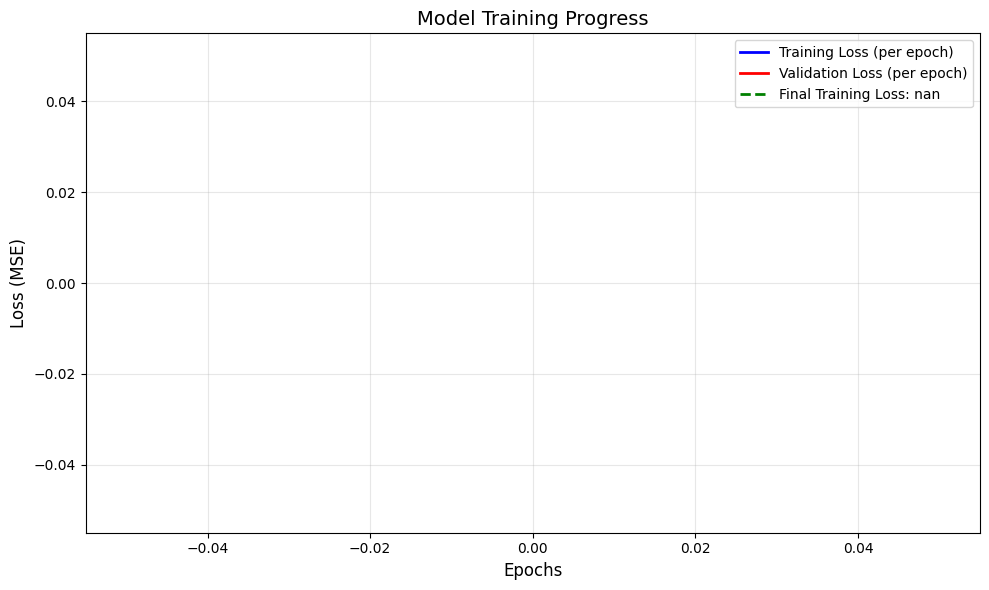

📊 Final Training Loss (MSE): nan
📊 Final Validation Loss (MSE): nan
📈 Generalization gap: nan
📊 Final Training RMSE: nan
📊 Final Validation RMSE: nan


In [28]:
# Plot training loss
plt.figure(figsize=(10, 6))

# Plot training loss from history (per epoch)
plt.plot(history.history['loss'], label='Training Loss (per epoch)', color='blue', linewidth=2)

# Plot validation loss if available
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss (per epoch)', color='red', linewidth=2)

# Add final training loss line
plt.axhline(y=train_loss, color='green', linestyle='--', linewidth=2, label=f'Final Training Loss: {train_loss:.2f}')

plt.title('Model Training Progress', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"📊 Final Training Loss (MSE): {train_loss:.4f}")

# Also show other metrics if available
if 'val_loss' in history.history:
    final_val_loss = history.history['val_loss'][-1]
    print(f"📊 Final Validation Loss (MSE): {final_val_loss:.4f}")
    print(f"📈 Generalization gap: {abs(train_loss - final_val_loss):.4f}")

# Calculate and display RMSE
train_rmse = np.sqrt(train_loss)
print(f"📊 Final Training RMSE: {train_rmse:.2f}")

if 'val_loss' in history.history:
    val_rmse = np.sqrt(final_val_loss)
    print(f"📊 Final Validation RMSE: {val_rmse:.2f}")

In [29]:
# Safe calculation with robust NaN handling
def safe_mse(y_true, y_pred):
    """Calculate MSE safely, handling NaN and Inf values"""
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Remove NaN and Inf values
    mask = ~(np.isnan(y_true) | np.isnan(y_pred) | np.isinf(y_true) | np.isinf(y_pred))

    if np.sum(mask) == 0:
        print("⚠️ Warning: No valid data points after filtering NaN/Inf")
        return np.nan

    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]

    print(f"Using {np.sum(mask)}/{len(y_true)} valid data points")

    return mean_squared_error(y_true_clean, y_pred_clean)

# Get predictions
train_preds = model.predict(X_train_seq, verbose=0).flatten()

# Calculate loss safely
actual_train_loss = safe_mse(y_train_seq, train_preds)

if not np.isnan(actual_train_loss):
    print(f"✅ Precise Training Loss (MSE): {actual_train_loss:.4f}")
    print(f"✅ Precise Training RMSE: {np.sqrt(actual_train_loss):.2f}")
else:
    print("❌ Could not calculate valid loss due to too many NaN/Inf values")

⚠️ Warning: No valid data points after filtering NaN/Inf
❌ Could not calculate valid loss due to too many NaN/Inf values


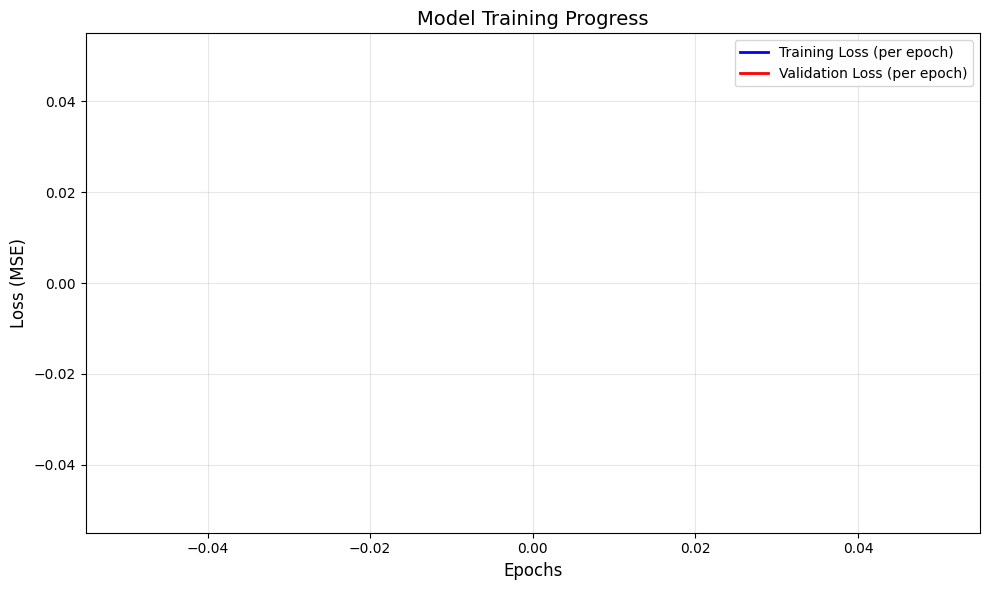

In [30]:
# Plot training loss (with safe values)
plt.figure(figsize=(10, 6))

# Plot training loss from history
plt.plot(history.history['loss'], label='Training Loss (per epoch)', color='blue', linewidth=2)

# Plot validation loss if available
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss (per epoch)', color='red', linewidth=2)

# Add final training loss line (only if valid)
if not np.isnan(actual_train_loss):
    plt.axhline(y=actual_train_loss, color='green', linestyle='--', linewidth=2,
               label=f'Final Training Loss: {actual_train_loss:.2f}')

plt.title('Model Training Progress', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display final metrics
if not np.isnan(actual_train_loss):
    print(f"📊 Final Training Loss (MSE): {actual_train_loss:.4f}")
    print(f"📊 Final Training RMSE: {np.sqrt(actual_train_loss):.2f}")

In [31]:
# Prepare the test data CORRECTLY - use the same processing as training
print("🔧 Preparing test data with correct format...")

# Use the aligned and scaled test data that matches your training format
# X_test_scaled should have shape (13148, 45) - same as X_train_scaled
print(f"X_test_scaled shape: {X_test_scaled.shape}")

# Create test sequences using the SAME method as training
test_sequences = []
for i in range(len(X_test_scaled)):
    if i < SEQUENCE_LENGTH:
        needed_from_train = SEQUENCE_LENGTH - (i + 1)
        if needed_from_train > 0:
            sequence = np.vstack([X_train_scaled[-needed_from_train:], X_test_scaled[:i+1]])
        else:
            sequence = X_test_scaled[:SEQUENCE_LENGTH]
    else:
        sequence = X_test_scaled[i-SEQUENCE_LENGTH+1:i+1]

    if sequence.shape[0] != SEQUENCE_LENGTH:
        if sequence.shape[0] < SEQUENCE_LENGTH:
            padding_needed = SEQUENCE_LENGTH - sequence.shape[0]
            padding = np.repeat(sequence[0:1], padding_needed, axis=0)
            sequence = np.vstack([padding, sequence])
        else:
            sequence = sequence[-SEQUENCE_LENGTH:]

    test_sequences.append(sequence)

X_test_seq = np.array(test_sequences)
print(f"📊 Test sequences shape: {X_test_seq.shape}")  # Should be (13148, 36, 45)

# Now make predictions with the CORRECT data format
print("🔮 Making predictions with correct data format...")
predictions = model.predict(X_test_seq, verbose=0)

# Ensure predictions do not contain NaN values and are non-negative
predictions = np.nan_to_num(predictions)
predictions = np.maximum(predictions.flatten(), 0)  # Ensure non-negative

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

print(f"✅ Predictions shape: {predictions.shape}")
print(f"📊 Predictions range: {predictions.min()} to {predictions.max()}")

🔧 Preparing test data with correct format...
X_test_scaled shape: (13148, 45)
📊 Test sequences shape: (13148, 36, 45)
🔮 Making predictions with correct data format...
✅ Predictions shape: (13148,)
📊 Predictions range: 0 to 0


In [32]:
# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/sample_submission.csv', index=False)

from google.colab import files
files.download('/sample_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>